# 

**Example use case: estimating the upper quantile of the incubation period distribution**

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count

In [ ]:
# notes from spreadsheet
# characterise upper quantile e.g. 95% of incubation period to estimate the duration of contact tracing follow up
# Can get a central estimate from the central estimate of mean and central estimate of sd but cannot get uncertainty around that

## inspiration: https://www.nejm.org/doi/suppl/10.1056/NEJMc1414992/suppl_file/nejmc1414992_appendix.pdf

## Table S2 (Guinea)
## given a mean and SD with uncertainty around it
## overall: mean 12.6 (9.1 - 17.1) SD 13.1 (9.6 - 19.6)

mean_c <- 12.6
sd_c <- 13.1

# bounds which we'll use in our simulation to generate the "true" distribution
mean_l <- 9.1
mean_u <- 17.1
sd_l <- 9.6
sd_u <- 19.6


In [ ]:
## generate a full set of samples - taken as the "true" distribution which the analysis is based on

n_samples <- 1000
n_iter <- 100

samples <- matrix(NA,nrow=n_samples,ncol=n_iter)
for(i in 1:n_iter){
  
  ## sample a mean & SD
  mean_iter <- rnorm(n=1,mean=mean_c,sd=(mean_u-mean_l)/3.92)
  sd_iter <- rnorm(n=1,mean=sd_c,sd=(sd_u-sd_l)/3.92)
  
  # generate parameters accordingly
  param_iter <- convert_summary_stats_to_params(x="gamma",
                                                mean=mean_iter,sd=sd_iter)

  samples[,i] <- rgamma(n=n_samples, 
                        shape = param_iter$shape, scale = param_iter$scale)
}

## for plotting
samples_longer <- pivot_longer(data.frame(samples),cols=paste0("X",seq(1:n_iter)))


In [ ]:
## now we don't have the full set of samples and we try to generate the 95% quantile 

## shape (alpha)
param1 <- convert_summary_stats_to_params(x="gamma",mean=mean_c,sd=sd_c)

# estimate 95% quantile
qgamma(p=0.95,shape = param1$shape, scale = param1$scale) ## 38.08


[1] 38.80294

[1] 12.6866

     95% 
38.81666 

The incubation period, defined as the time between infection and the development of symptoms, is an important epidemiological quantity for establishing guidance on the duration of contact tracing of identified cases, as well as the duration of isolation or quarantine for subsequently identified contacts. It is critical that the duration of isolation mitigates the risk of onward transmission, but does not extend any longer than necessary due to the costs, both financial and social, associated with isolation.  
The incubation period is most typically presented as a probability distribution, but is often summarised by a mean and estimate of the variability (most commonly standard deviation), rather than the full distribution.  
Consider the following example. During a novel Ebola outbreak, the incubation period is estimated using a gamma distribution on just a small number of observations (due to the lack of testing and contact tracing). MCMC methods are used to obtain 100 realisations of a gamma distribution:

(`stat_ecdf()`).

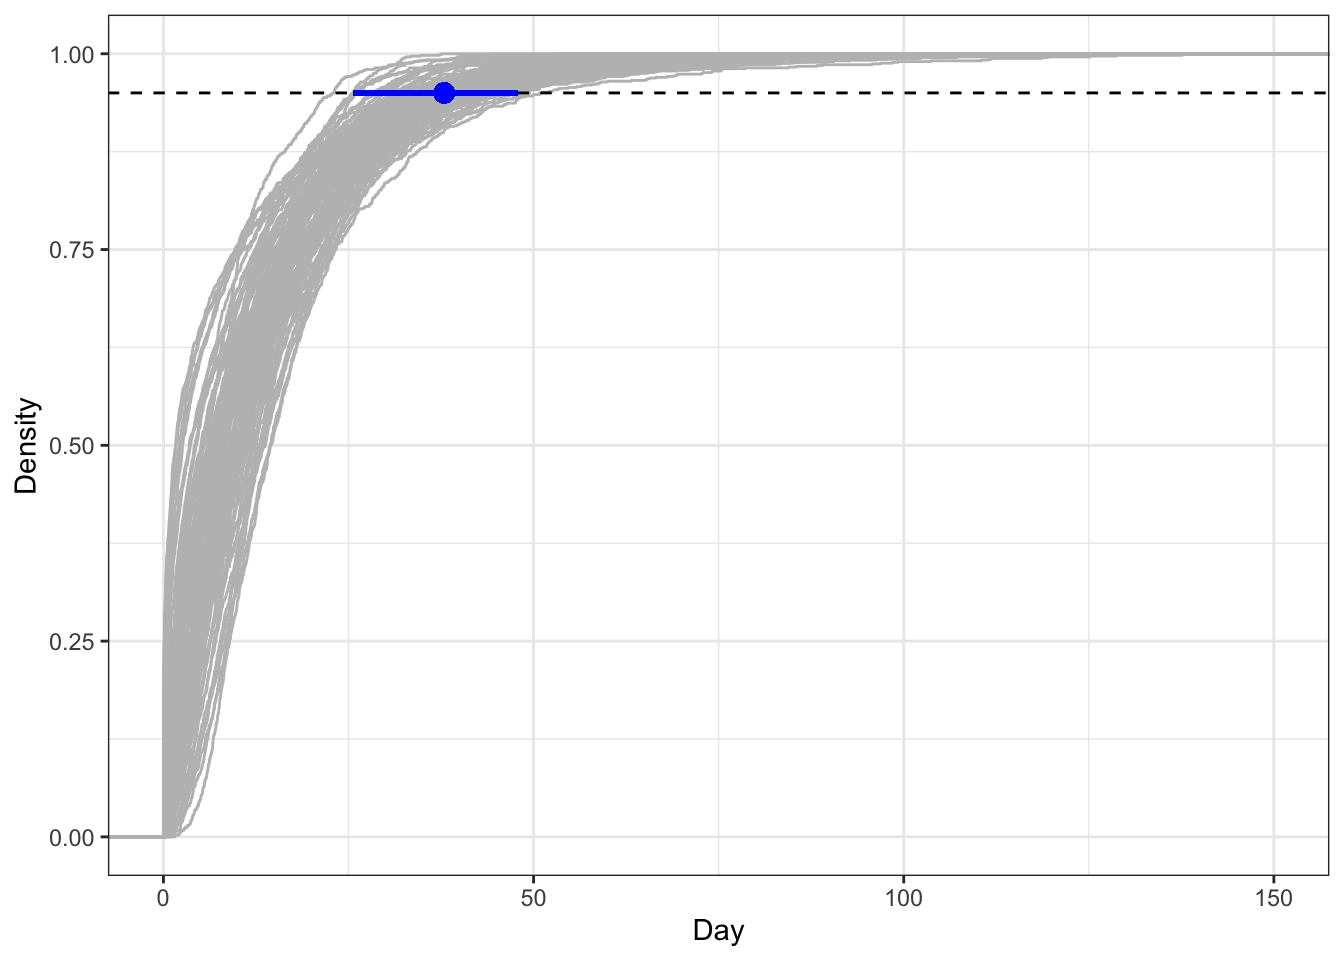

In [ ]:
# ggplot(samples_longer,
#        aes(x=value,group=name))+
#   geom_density(lwd=0.01,col="grey")+
#   theme_bw()+
#   labs(x="Day",y="Density",col="")+
#   xlim(c(0,100))

q95 <- mean(colQuantiles(samples,probs=0.95)) 
l95 <- quantile(colQuantiles(samples,probs=0.95),0.025)
u95 <- quantile(colQuantiles(samples,probs=0.95),0.975)

ggplot(samples_longer,
       aes(x=value,group=name))+
  stat_ecdf(geom = "step",col="grey")+
  geom_hline(aes(yintercept=0.95),linetype="dashed")+ 
  geom_point(aes(x=q95,y=0.95),col="blue",size=3)+
  geom_linerange(aes(y=0.95,xmin=l95,xmax=u95),col="blue",lwd=1)+
  theme_bw()+
  labs(x="Day",y="Density",col="")+
  xlim(c(0,150))+
  ylim(c(0,1))


This analysis has been repeated several times for this paper, corresponding to different locations and time periods. For sake of space and simplicity, the results per fit are presented in the typical fashion, as noted above:  
Mean: 12.49 (95% CI 8.52 - 16.64)  
SD: 12.92 (95% CI 7.74 - 17.2)  
However, this omits critical information about the upper 95% quantile of the distribution, which from the figure, is highly variable across realisations. Specifically, this is estimated as:  
95% quantile: 37.9 (95% CI 25.7 - 47.8)  
which has substantial uncertainty.  
In a future outbreak of a viral hemorrhagic fever, the public health authority in the affected country looks to the previous analysis to guide their quarantine policy. Using only the provided information (the mean and SD), it is possible to use method of moments for the gamma distribution to obtain estimates of the shape and scale parameters (0.93 and 13.62, respectively). Parameterising a gamma distribution according to these parameters corresponds to a 95% quantile of 39 days. This recovers the central estimate above well. However, it is not possible to obtain any uncertainty around this estimate without the authors having provided the full set of samples used to generate these estimates. This may provide a false sense of certainty on which the quarantine policy is based, whereas there may be an argument to either extend or reduce this based on the considerable uncertainty estimated above.